In [1]:
import os
import re

from tqdm import tqdm
import time
import math
import statistics

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sodapy import Socrata
%matplotlib inline

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, RidgeCV, ElasticNetCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, plot_confusion_matrix, plot_roc_curve

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline


pd.set_option('display.max_rows', 1000)

Merge final DF's for each year

In [2]:
df1 = pd.read_csv('/Users/ksalmon/Desktop/GA/DSI20-lessons/projects/project-capstone/merge2016.csv')

In [3]:
df2 = pd.read_csv('/Users/ksalmon/Desktop/GA/DSI20-lessons/projects/project-capstone/merge2017.csv')

In [4]:
df3 = pd.read_csv('/Users/ksalmon/Desktop/GA/DSI20-lessons/projects/project-capstone/merge2017.csv')

In [5]:
df4 = pd.read_csv('/Users/ksalmon/Desktop/GA/DSI20-lessons/projects/project-capstone/merge2017.csv')

In [6]:
df5 = pd.read_csv('/Users/ksalmon/Desktop/GA/DSI20-lessons/projects/project-capstone/merge2017.csv')

In [7]:
dfs = [df1, df2, df3, df4, df5]

In [8]:
all_merged = pd.concat(dfs, axis=0)

In [9]:
all_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201318 entries, 0 to 445756
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   descriptor      object 
 2   agency          object 
 3   complaint_type  object 
 4   zipyear         int64  
 5   ppu             float64
dtypes: float64(1), int64(2), object(3)
memory usage: 117.6+ MB


In [10]:
all_merged.drop(columns = ['Unnamed: 0', 'agency'], inplace=True)

In [11]:
all_merged.dropna(axis=0, inplace=True)

In [12]:
all_merged['ppu'].describe()

count    2.199949e+06
mean     7.574627e+05
std      7.225106e+05
min      1.381628e+05
25%      3.454377e+05
50%      5.125945e+05
75%      9.401560e+05
max      5.171098e+06
Name: ppu, dtype: float64

In [13]:
all_merged

,descriptor,complaint_type,zipyear,ppu
0,Loud Music/Party,Noise - Residential,104632016,3.407297e+05
1,Loud Music/Party,Noise - Residential,100402016,5.457485e+05
2,Loud Talking,Noise - Residential,100122016,3.715735e+06
3,Loud Music/Party,Noise - Residential,111042016,3.813583e+05
4,Loud Music/Party,Noise - Residential,100322016,5.006615e+05
...,...,...,...,...
445752,Loud Music/Party,Noise - Residential,104582017,2.442623e+05
445753,Loud Music/Party,Noise - Residential,116912017,3.044278e+05
445754,Banging/Pounding,Noise - Residential,112142017,4.793599e+05
445755,Loud Music/Party,Noise - Residential,100402017,5.692389e+05


In [381]:
all_merged.to_csv('/Users/ksalmon/Desktop/GA/DSI20-lessons/projects/project-capstone/all_merged.csv')

Check dependency between descriptor and complaint type. Initiail hypothesis is that they are independent.

In [382]:
chisq = all_merged.copy()

In [383]:
chisq.drop(columns=['zipyear'], inplace=True)

In [384]:
crosstab = pd.crosstab(chisq['descriptor'], chisq['complaint_type'])
crosstab

In [ ]:
stat, p, dof, expected = chi2_contingency(crosstab)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Create 2 binary targets. One based on median and one on median

In [15]:
all_feats = all_merged.copy()

In [16]:
mu = all_feats.ppu.mean()

In [217]:
mu

757462.7233977048

In [218]:
median = all_feats['ppu'].median()

In [219]:
median

512594.4991957612

In [220]:
all_feats['price_mu'] = ['high' if x >= mu else 'low' for x in all_feats.ppu]

In [221]:
all_feats['price_median'] = ['high' if x >= median else 'low' for x in all_feats.ppu]

In [222]:
all_feats.head()

,descriptor,complaint_type,zipyear,ppu,price_mu,price_median
0,Loud Music/Party,Noise - Residential,104632016,3.407297e+05,low,low
1,Loud Music/Party,Noise - Residential,100402016,5.457485e+05,low,high
2,Loud Talking,Noise - Residential,100122016,3.715735e+06,high,high
3,Loud Music/Party,Noise - Residential,111042016,3.813583e+05,low,low
4,Loud Music/Party,Noise - Residential,100322016,5.006615e+05,low,low


<AxesSubplot:xlabel='price_mu', ylabel='Count'>

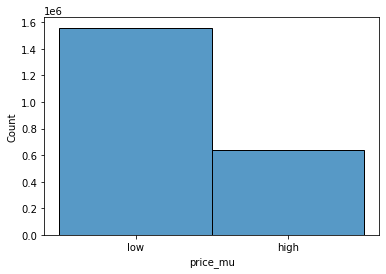

In [223]:
sns.histplot(data=all_feats['price_mu'])

In [224]:
all_feats['price_mu'].value_counts(normalize=True)

low     0.708656
high    0.291344
Name: price_mu, dtype: float64

<AxesSubplot:xlabel='price_median', ylabel='Count'>

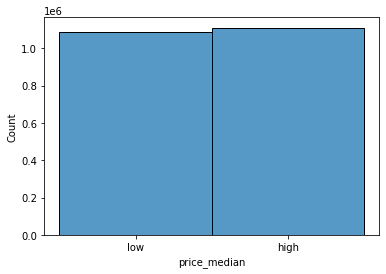

In [225]:
sns.histplot(data=all_feats['price_median'])

In [226]:
all_feats['price_median'].value_counts(normalize=True)

high    0.504658
low     0.495342
Name: price_median, dtype: float64

In [17]:
all_feats.drop(columns=['zipyear', 'ppu'], inplace=True)

Dummify features

In [18]:
af_dum = pd.get_dummies(all_feats, drop_first=True)

In [19]:
af_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199949 entries, 0 to 445756
Data columns (total 34 columns):
 #   Column                                                            Dtype
---  ------                                                            -----
 0   descriptor_Banging/Pounding                                       uint8
 1   descriptor_Car/Truck Horn                                         uint8
 2   descriptor_Car/Truck Music                                        uint8
 3   descriptor_Engine Idling                                          uint8
 4   descriptor_Loud Music/Party                                       uint8
 5   descriptor_Loud Talking                                           uint8
 6   descriptor_Loud Television                                        uint8
 7   descriptor_NYPD                                                   uint8
 8   descriptor_News Gathering                                         uint8
 9   descriptor_Noise, Barking Dog (NR5) 

Initial heatmap of all features

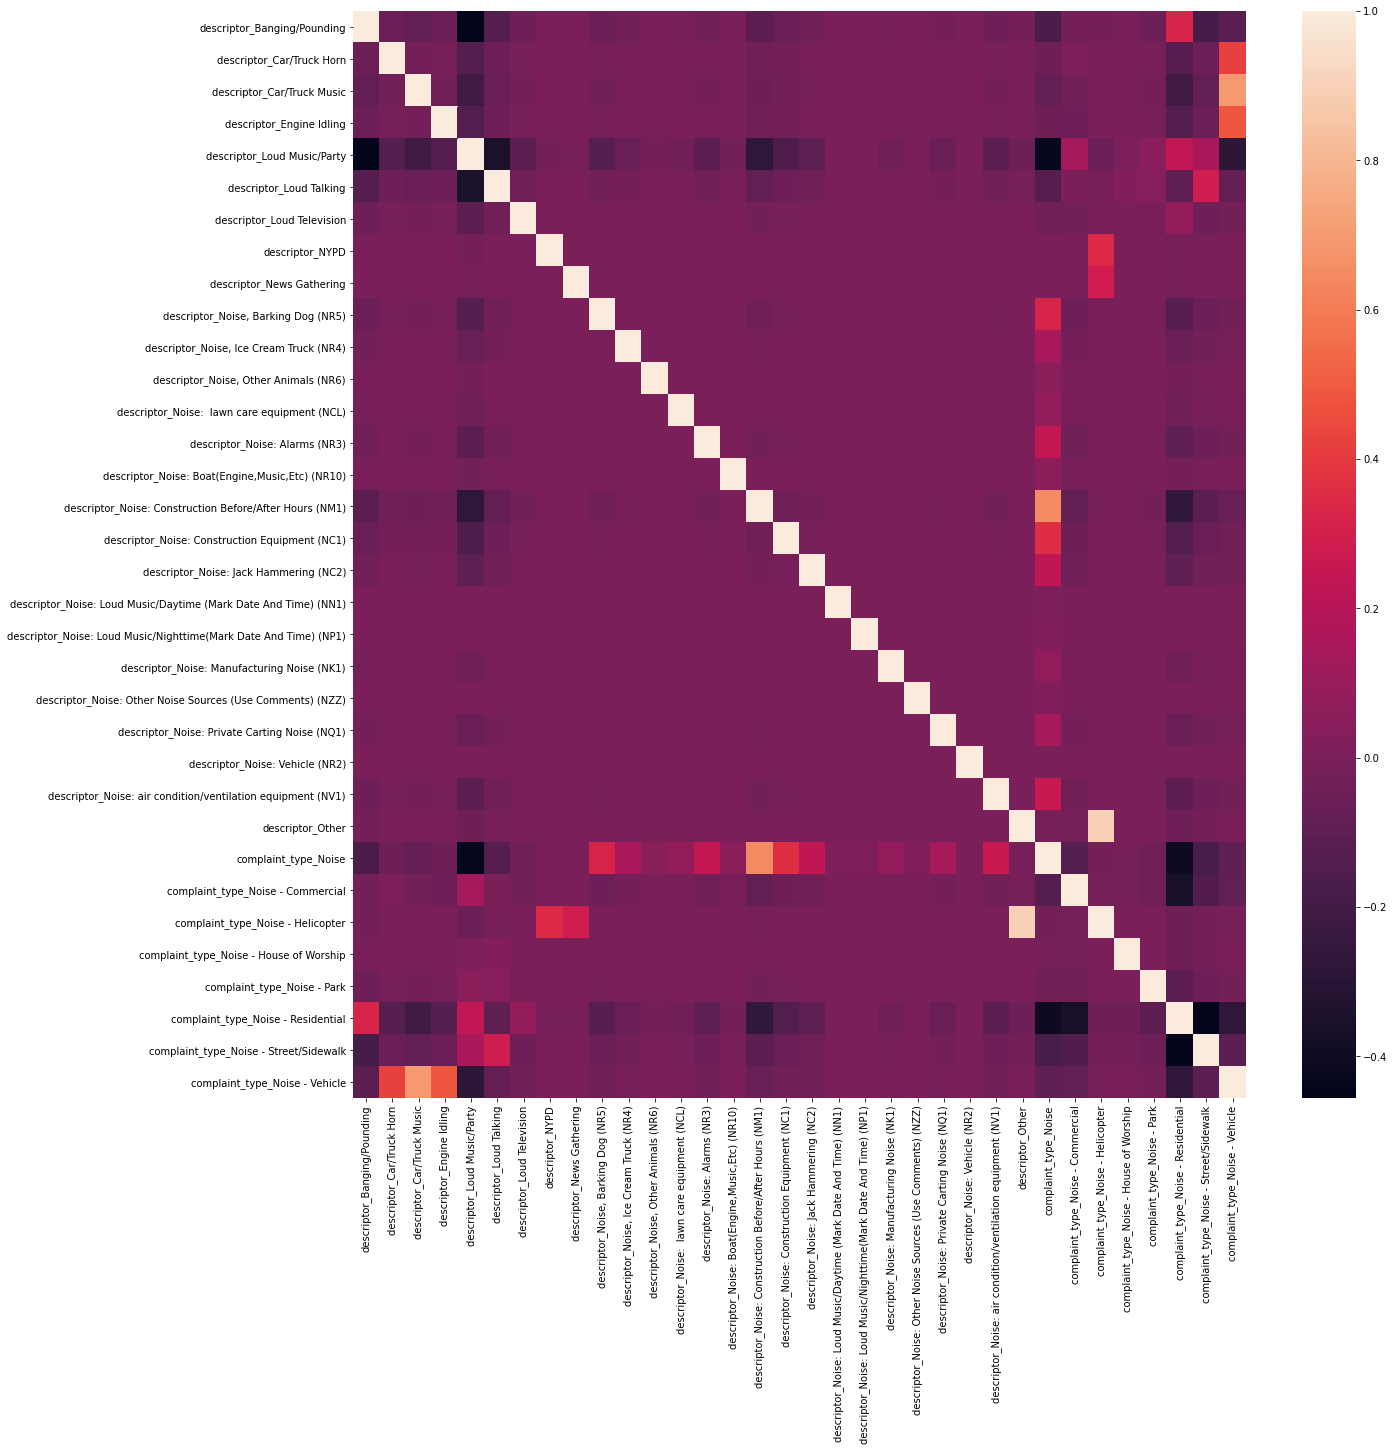

In [20]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(af_dum.corr(), annot=False, ax=ax)
ax.set_ylim([af_dum.shape[1], 0])
plt.show()

I first ran a LogReg model with the mean as Target. Then ran the initial LogReg model with median as target. The code below is set up for the median because that's what I ended up moving forward with.

In [236]:
# Separate target variable for median
X = af_dum.copy()
y = X.pop('price_median_low')

In [237]:
X.drop(columns=['price_mu_low'], inplace=True)

In [238]:
# Baseline
y.value_counts(normalize=True)

0    0.504658
1    0.495342
Name: price_median_low, dtype: float64

In [239]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

In [231]:
# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [243]:
model = LogisticRegression(penalty='none', max_iter=1000, n_jobs=-1)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5, verbose=1)

print(model.score(X_train, y_train))
print(scores)
print(np.mean(scores))
print(model.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.7min finished


0.6295800072615328
[0.62941203 0.62910805 0.62965067 0.62896032 0.63005588]
0.6294373906542662
0.6288574740335008


In [245]:
mean_absolute_error(y_test, model.predict(X_test))

36.20038864519648

Get coefs for LogReg with median

In [314]:
# collect the model coefficients in a dataframe
l2_coef = pd.DataFrame(model.coef_.T, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
l2_coef['coef_abs'] = l2_coef.coefficients.abs()
l2_coef.sort_values('coef_abs', ascending=False)

,coefficients,coef_abs
descriptor_Car/Truck Music,1.330128,1.330128
"descriptor_Noise, Other Animals (NR6)",1.278183,1.278183
descriptor_Noise: Jack Hammering (NC2),-1.055075,1.055075
complaint_type_Noise - Residential,0.919271,0.919271
"descriptor_Noise, Barking Dog (NR5)",0.849172,0.849172
"descriptor_Noise, Ice Cream Truck (NR4)",0.832540,0.832540
complaint_type_Noise - House of Worship,0.711451,0.711451
descriptor_Noise: lawn care equipment (NCL),0.711036,0.711036
descriptor_Noise: Construction Before/After Hours (NM1),-0.705008,0.705008
descriptor_Noise: Loud Music/Nighttime(Mark Date And Time) (NP1),0.624837,0.624837


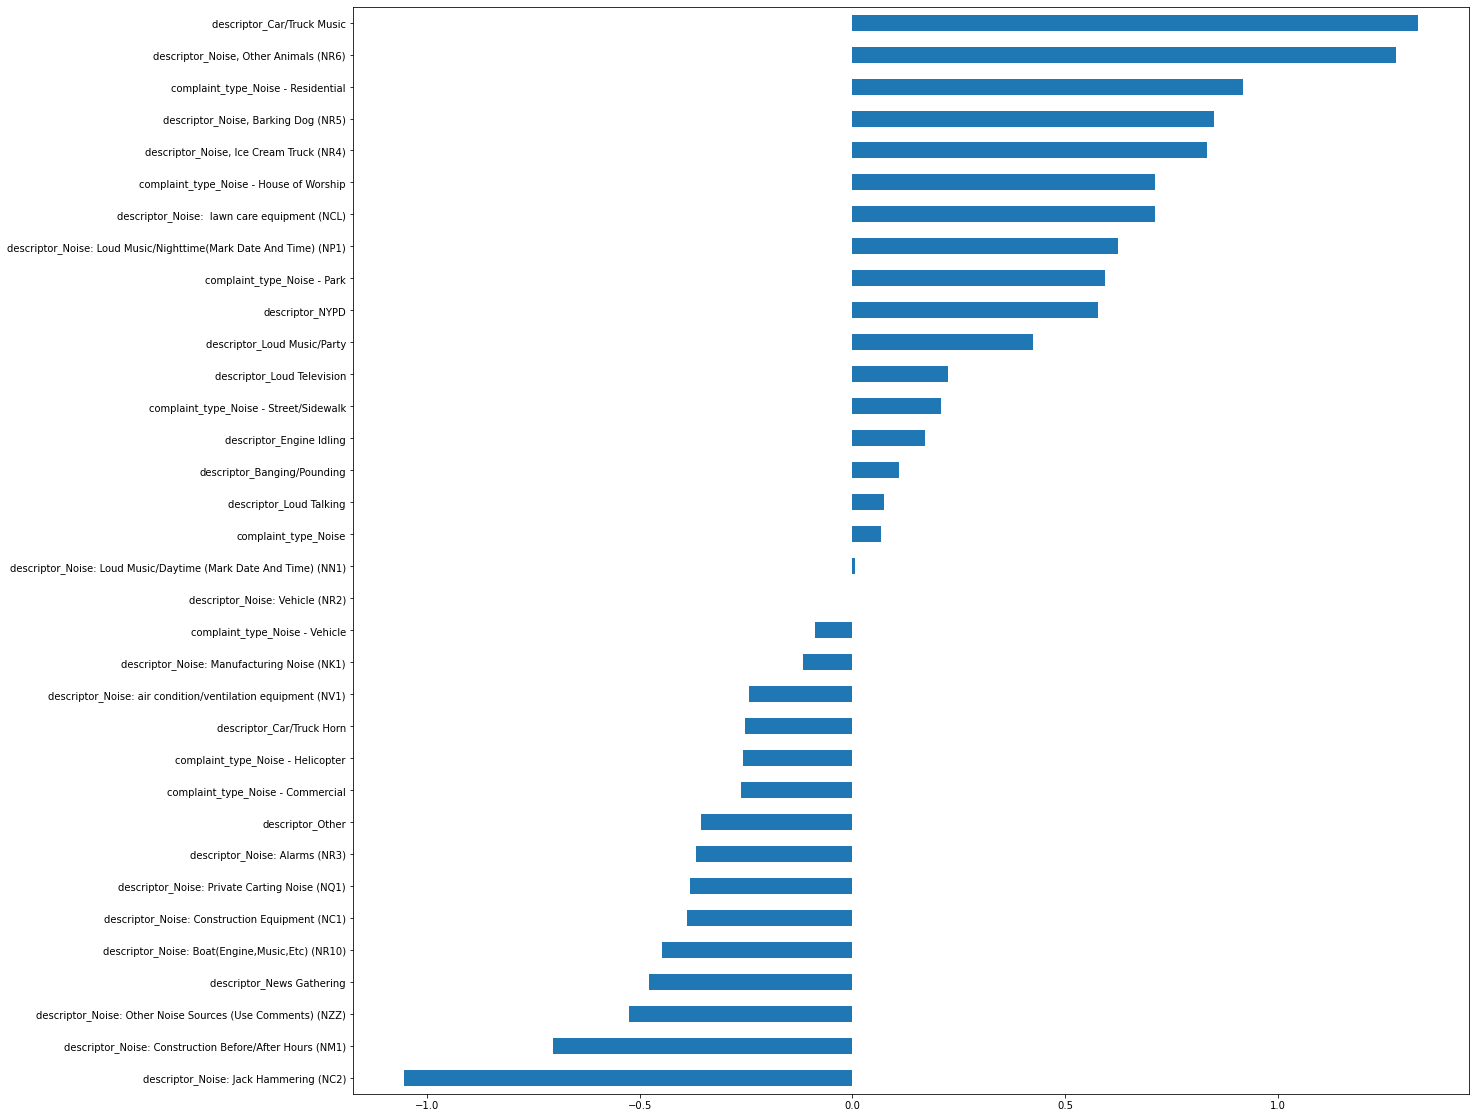

In [315]:
# plot the magnitude of the coefficients
plt.figure(figsize=(20, 20))
l2_coef['coefficients'].sort_values().plot(kind='barh');

ROC curve for LogReg with median

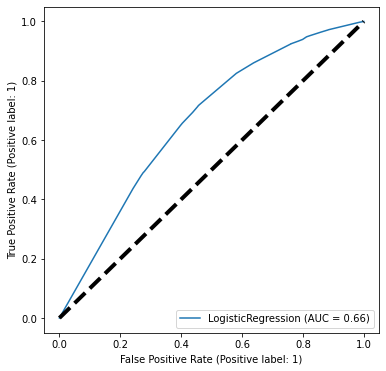

In [254]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(model, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

Confusion matrix for LogReg with median

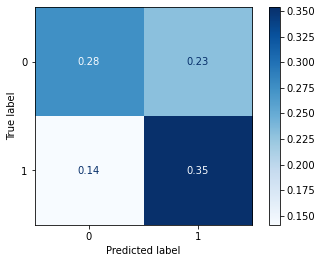

In [248]:
plot_confusion_matrix(model, X_test, y_test, labels=[0, 1,], cmap='Blues', normalize = 'all')
plt.grid(False)
plt.show()

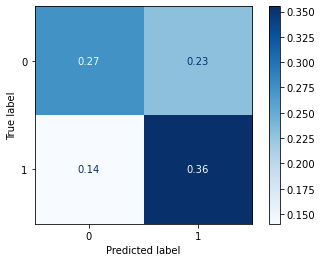

In [249]:
plot_confusion_matrix(model, X_train, y_train, labels=[0, 1,], cmap='Blues', normalize = 'all')
plt.grid(False)
plt.show()

Gridsearch for LogReg with median

In [250]:
# lr = LogisticRegression()

In [244]:
# setup the grid search


# params = {'C': np.logspace(-4, 4, 10),
#           'max_iter': [500],
#           'penalty': ['elasticnet'],
#           'l1_ratio': [0.1, 0.2, 0.5, 0.75, 0.9],
#           'fit_intercept': [True, False],
#            'tol': [0.001],
#          'solver': ['saga']}

# gs = GridSearchCV(estimator=lr,
#                   param_grid=params,
#                   cv=5,
#                   verbose=1,
#                   scoring='accuracy',
#                   return_train_score=True)

# gs.fit(X_train, y_train)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'fit_intercept': [True, False],
                         'l1_ratio': [0.1, 0.2, 0.5, 0.75, 0.9],
                         'max_iter': [500], 'penalty': ['elasticnet'],
                         'solver': ['saga'], 'tol': [0.001]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [245]:

# print('Best Parameters:')
# print(gs.best_params_)
# print('Best estimator C:')
# print(gs.best_estimator_.C)
# print('Best estimator mean cross validated training score:')
# print(gs.best_score_)
# print('Best estimator score on the full training set:')
# print(gs.score(X_train, y_train))
# print('Best estimator score on the test set:')
# print(gs.score(X_test, y_test))
# print('Best estimator coefficients:')
# print(gs.best_estimator_.coef_)

Best Parameters:
{'C': 0.005994842503189409, 'fit_intercept': False, 'l1_ratio': 0.1, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.001}
Best estimator C:
0.005994842503189409
Best estimator mean cross validated training score:
0.6295731893404228
Best estimator score on the full training set:
0.6295890983824055
Best estimator score on the test set:
0.6287961090024773
Best estimator coefficients:
[[ 8.40882810e-03 -4.17175528e-02  2.32896647e-01  9.47900659e-03
   1.69043160e-01 -2.75307047e-03  1.33158171e-02  6.74564749e-03
  -8.86388416e-03  1.18723876e-01  5.54297669e-02  2.48456443e-02
   2.82578448e-02 -2.34985620e-02 -7.23695941e-03 -1.38819659e-01
  -3.79625998e-02 -8.25741137e-02  3.51415128e-04  4.87992406e-03
   1.71642703e-07 -3.61454788e-03 -1.50066326e-02  0.00000000e+00
  -1.29433952e-02 -2.26254933e-02 -1.04871339e-01 -1.36484402e-01
  -1.65250304e-02  2.40576404e-02  4.11653368e-02  3.69959411e-01
   9.99684467e-03 -6.29063360e-02]]


In [ ]:
# setup the grid search


# params = {'C': np.logspace(-4, 4, 10),
#           'max_iter': [500],
#           'penalty': ['elasticnet'],
#           'l1_ratio': [0.1, 0.2, 0.5, 0.75, 0.9],
#           'fit_intercept': [True, False],
#            'tol': [0.001],
#          'solver': ['saga']}

# gs = GridSearchCV(estimator=lr,
#                   param_grid=params,
#                   cv=5,
#                   verbose=1,
#                   scoring='accuracy',
#                   return_train_score=True)

# gs.fit(X_train, y_train)


In [248]:
# print('Best Parameters:')
# print(gs.best_params_)
# print('Best estimator C:')
# print(gs.best_estimator_.C)
# print('Best estimator mean cross validated training score:')
# print(gs.best_score_)
# print('Best estimator score on the full training set:')
# print(gs.score(X_train, y_train))
# print('Best estimator score on the test set:')
# print(gs.score(X_test, y_test))
# print('Best estimator coefficients:')
# print(gs.best_estimator_.coef_)

Best Parameters:
{'C': 0.000774263682681127, 'fit_intercept': False, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Best estimator C:
0.000774263682681127
Best estimator mean cross validated training score:
0.6295731893404228
Best estimator score on the full training set:
0.6295890983824055
Best estimator score on the test set:
0.6287961090024773
Best estimator coefficients:
[[-1.85108454e-02 -5.48899241e-02  2.11837902e-01 -4.39100458e-03
   1.30931240e-01 -2.50033877e-02  6.07854610e-03  5.98274843e-03
  -9.53283381e-03  1.05953867e-01  4.93661005e-02  2.30147072e-02
   2.47322296e-02 -3.29550314e-02 -9.48692785e-03 -1.62522883e-01
  -5.19393635e-02 -9.13471747e-02  9.83285558e-05  4.38439587e-03
  -2.92307013e-03 -4.22301872e-03 -2.06462118e-02  0.00000000e+00
  -2.32614760e-02 -2.46217445e-02 -1.29456353e-01 -1.65781780e-01
  -2.26681316e-02  1.96626773e-02  3.14847068e-02  3.21065975e-01
  -2.53609409e-02 -7.80959220e-02]]


This was an initial model I ran with the mean as the target before I started using the median as the target. It wasn't useful.

In [120]:
# This came out with really really low scores and an alpha of .01
# Elastic Net model is worse than baseline
# create an ElastinNetCV model instance
# encv = LogisticRegressionCV(Cs=np.logspace(-4, 4, 20), 
#                                 l1_ratios=[0.001, 0.01, 0.05, 0.1, 0.5],
#                                 solver='saga', 
#                                 penalty='elasticnet', cv=5)
# encv.fit(X_train, y_train)

# print(encv.score(X_train, y_train))
# print(scores)
# print(np.mean(scores))
# print(encv.score(X_test, y_test))

Look at Lasso vs. Ridge with mean as target. I was hoping Lasso would zero out some of my smaller features but then again my features 
have some collinearity 

In [1]:
# Lasso
# model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, tol=0.001, verbose=1, n_jobs=-1)
# model.fit(X_train, y_train)
# scores = cross_val_score(model, X_train, y_train, cv=5)

# print(model.score(X_train, y_train))
# print(scores)
# print(np.mean(scores))
# print(model.score(X_test, y_test))

In [71]:
mean_absolute_error(y_test, model.predict(X_test))

14.147985181481397

In [ ]:
# Get coefs

In [65]:
# collect the model coefficients in a dataframe
lasso_coef = pd.DataFrame(model.coef_.T, index=X.columns,
                       columns=['coefficients'])

# calculate the absolute values of the coefficients
lasso_coef['coef_abs'] = lasso_coef.coefficients.abs()
lasso_coef.sort_values('coef_abs', ascending=False)

,coefficients,coef_abs
complaint_type_Noise - Residential,0.462753,0.462753
descriptor_Loud Music/Party,0.276818,0.276818
descriptor_Car/Truck Music,0.271331,0.271331
complaint_type_Noise - Commercial,-0.172915,0.172915
descriptor_Noise: Construction Before/After Hours (NM1),-0.167823,0.167823
"descriptor_Noise, Barking Dog (NR5)",0.133257,0.133257
complaint_type_Noise - Street/Sidewalk,0.126822,0.126822
descriptor_Noise: Alarms (NR3),0.118255,0.118255
descriptor_Noise: Jack Hammering (NC2),-0.096337,0.096337
complaint_type_Noise,-0.083421,0.083421


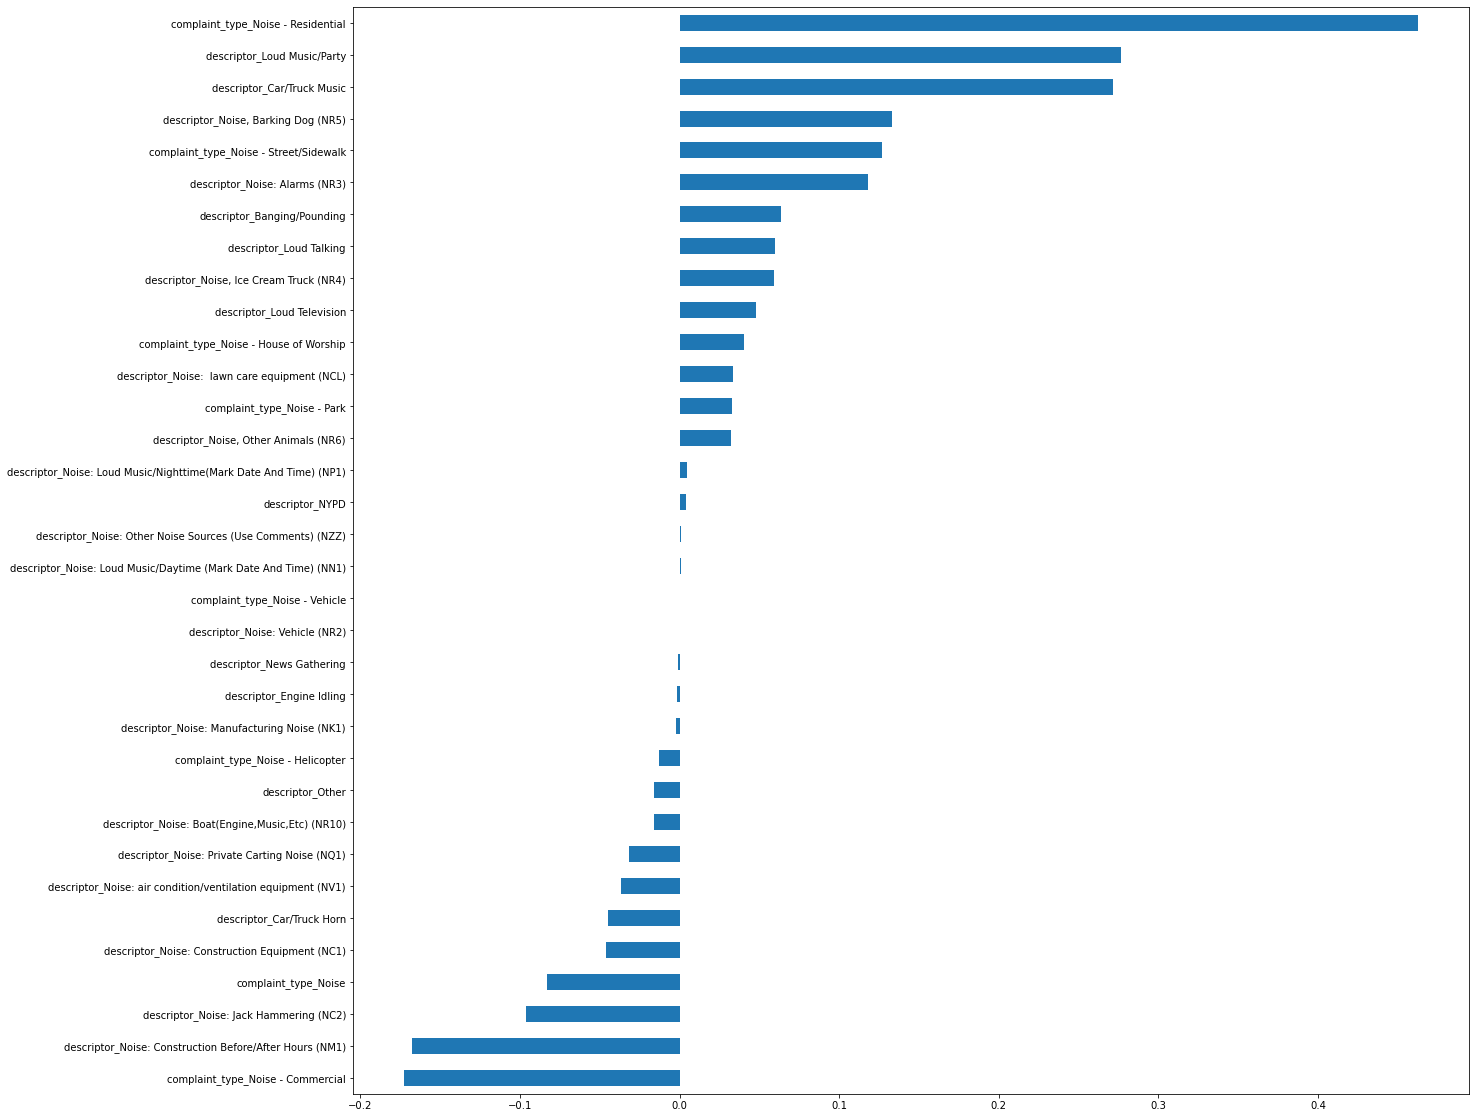

In [66]:
# plot the magnitude of the coefficients
plt.figure(figsize=(20, 20))
lasso_coef['coefficients'].sort_values().plot(kind='barh');

In [70]:
# Fit logistic regression w Ridge
model = LogisticRegressionCV(penalty='l2', max_iter=1000, solver='lbfgs', Cs=np.logspace(-4, 4, 10), cv=5,
                            verbose=1, n_jobs=1, tol=0.001)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(scores)
print(np.mean(scores))
print(model.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.4s finished


0.7479066273702967
[0.74759654 0.74765904 0.74838917 0.74798007 0.74786287]
0.7478975362297277
0.7472851655719448


In [265]:
mean_absolute_error(y_test, model.predict(X_test))

14.198174958521784

These are the coeffs with lasso and ridge with mean as target.

In [75]:
# collect the model coefficients in a dataframe
l2_coef = pd.DataFrame(model.coef_.T, index=X.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
l2_coef['coef_abs'] = l2_coef.coefficients.abs()
l2_coef.sort_values('coef_abs', ascending=False)

,coefficients,coef_abs
complaint_type_Noise - Residential,0.309402,0.309402
complaint_type_Noise - Commercial,-0.256953,0.256953
descriptor_Noise: Construction Before/After Hours (NM1),-0.226908,0.226908
descriptor_Car/Truck Music,0.185134,0.185134
complaint_type_Noise,-0.181585,0.181585
descriptor_Loud Music/Party,0.144047,0.144047
descriptor_Noise: Jack Hammering (NC2),-0.117168,0.117168
"descriptor_Noise, Barking Dog (NR5)",0.097094,0.097094
descriptor_Car/Truck Horn,-0.094342,0.094342
descriptor_Noise: Alarms (NR3),0.090083,0.090083


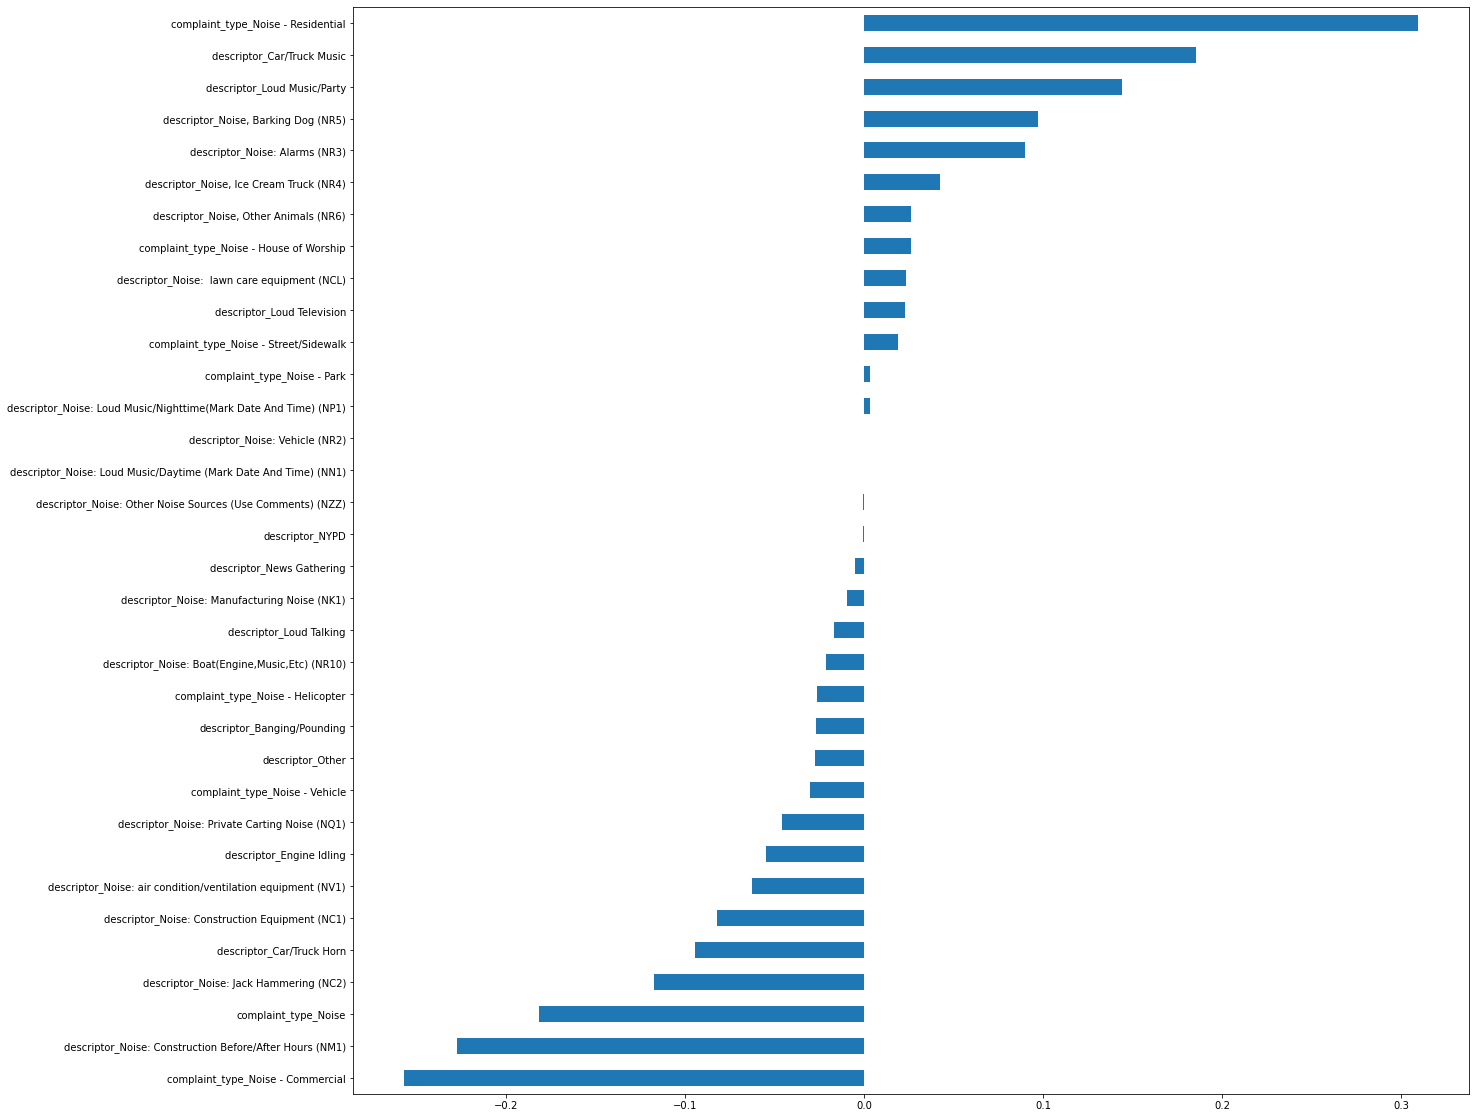

In [76]:
# plot the magnitude of the coefficients
plt.figure(figsize=(20, 20))
l2_coef['coefficients'].sort_values().plot(kind='barh');

Confusion matrix from log reg with mean as target

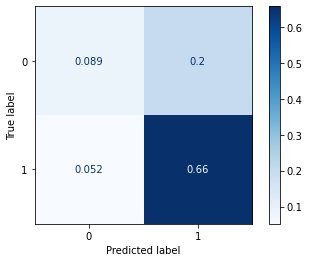

In [122]:
plot_confusion_matrix(model, X_test, y_test, labels=[0, 1,], cmap='Blues', normalize = 'all')
plt.grid(False)
plt.show()

In [261]:
# model = LogisticRegression(solver='liblinear')

In [264]:
# # setup the grid search

# params = {'C': np.logspace(-4, 4, 10),
#           'penalty': ['l1', 'l2'],
#           'fit_intercept': [True, False]}

# gs = GridSearchCV(estimator=model,
#                   param_grid=params,
#                   cv=5,
#                   scoring='accuracy',
#                   return_train_score=True)

# gs.fit(X_train, y_train)

# # extract the grid search results
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(solver='liblinear')
# model.fit(X, y)
# model.score(X, y)
 

Consolidate feature categories: descriptors and complaint types to see if that helps scores. tried this with both the mean and median as targets.

In [21]:
df = all_merged.copy()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199949 entries, 0 to 445756
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   descriptor      object 
 1   complaint_type  object 
 2   zipyear         int64  
 3   ppu             float64
dtypes: float64(1), int64(1), object(2)
memory usage: 83.9+ MB


In [23]:
df['descriptor'].value_counts()

Loud Music/Party                                         1190325
Banging/Pounding                                          329621
Loud Talking                                              206719
Noise: Construction Before/After Hours (NM1)              135230
Car/Truck Music                                            81248
Noise: Construction Equipment (NC1)                        43652
Engine Idling                                              35173
Car/Truck Horn                                             34645
Noise, Barking Dog (NR5)                                   34330
Noise: air condition/ventilation equipment (NV1)           23343
Loud Television                                            20543
Noise: Alarms (NR3)                                        19740
Noise: Jack Hammering (NC2)                                18232
Noise, Ice Cream Truck (NR4)                                7726
Noise: Private Carting Noise (NQ1)                          6813
Other                    

In [24]:
# Consolidate smaller categories in complaint_type and descriptor columns
descriptors = ['Noise: Private Carting Noise (NQ1)','NYPD', 'Noise:  lawn care equipment (NCL)',
              'Noise: Manufacturing Noise (NK1)', 'Noise: Boat(Engine,Music,Etc) (NR10)', '21 Collection Truck Noise',
              'Noise, Other Animals (NR6)', 'News Gathering', 'Noise: Other Noise Sources (Use Comments) (NZZ)',
              'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)', 'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)',
              'Noise: Vehicle (NR2)', 'Other', 'Noise, Ice Cream Truck (NR4)']

In [25]:
for i in descriptors:
    df.descriptor = df.descriptor.apply(lambda x: 'other' if i in x else x)

In [26]:
cars = ['Car/Truck Music', 'Engine Idling', 'Car/Truck Horn']

In [27]:
for i in cars:
    df.descriptor = df.descriptor.apply(lambda x: 'car noise' if i in x else x)

In [28]:
construction = ['Noise: Construction Before/After Hours (NM1)', 'Noise: Construction Equipment (NC1)', 'Noise: Jack Hammering (NC2)']

In [29]:
for i in construction:
    df.descriptor = df.descriptor.apply(lambda x: 'construction noise' if i in x else x)

In [30]:
df['descriptor'].value_counts()

Loud Music/Party                                    1190325
Banging/Pounding                                     329621
Loud Talking                                         206719
construction noise                                   197114
car noise                                            151066
Noise, Barking Dog (NR5)                              34330
other                                                 27148
Noise: air condition/ventilation equipment (NV1)      23343
Loud Television                                       20543
Noise: Alarms (NR3)                                   19740
Name: descriptor, dtype: int64

In [31]:
types = ['Park', 'Helicopter', 'Worship', 'Truck']

In [32]:
for i in types:
    df['complaint_type'] = df['complaint_type'].apply(lambda x: 'Noise' if i in x else x)

In [33]:
df['complaint_type'].value_counts()

Noise - Residential        1140849
Noise - Street/Sidewalk     351815
Noise                       328164
Noise - Commercial          238082
Noise - Vehicle             141039
Name: complaint_type, dtype: int64

In [34]:
median = df['ppu'].median()

In [35]:
df['price_median'] = ['high' if x >= median else 'low' for x in df['ppu']]

In [36]:
df.head(10)

,descriptor,complaint_type,zipyear,ppu,price_median
0,Loud Music/Party,Noise - Residential,104632016,3.407297e+05,low
1,Loud Music/Party,Noise - Residential,100402016,5.457485e+05,high
2,Loud Talking,Noise - Residential,100122016,3.715735e+06,high
3,Loud Music/Party,Noise - Residential,111042016,3.813583e+05,low
4,Loud Music/Party,Noise - Residential,100322016,5.006615e+05,low
5,Banging/Pounding,Noise - Residential,113852016,3.697745e+05,low
6,Loud Music/Party,Noise - Commercial,100032016,1.786469e+06,high
7,Loud Music/Party,Noise - Residential,112302016,6.202029e+05,high
8,Loud Music/Party,Noise - Commercial,113772016,3.707944e+05,low
9,Loud Talking,Noise - Residential,101282016,1.783553e+06,high


In [386]:
# sns.histplot(data=df['price_mean'])

In [192]:
df['price_mean'].value_counts(normalize=True)

low     0.708656
high    0.291344
Name: price_mean, dtype: float64

<AxesSubplot:xlabel='price_median', ylabel='Count'>

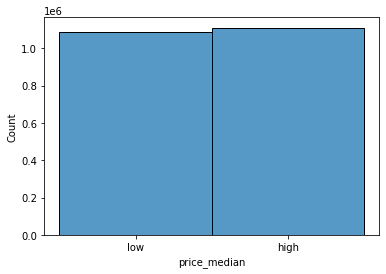

In [272]:
sns.histplot(data=df['price_median'])

In [280]:
df['price_median'].value_counts()

high    1110222
low     1089727
Name: price_median, dtype: int64

In [37]:
drop = df.drop(columns=['zipyear', 'ppu'])

In [38]:
drop.head()

,descriptor,complaint_type,price_median
0,Loud Music/Party,Noise - Residential,low
1,Loud Music/Party,Noise - Residential,high
2,Loud Talking,Noise - Residential,high
3,Loud Music/Party,Noise - Residential,low
4,Loud Music/Party,Noise - Residential,low


In [39]:
df_dum = pd.get_dummies(drop, drop_first=True)
df_dum.head()

,descriptor_Loud Music/Party,descriptor_Loud Talking,descriptor_Loud Television,"descriptor_Noise, Barking Dog (NR5)",descriptor_Noise: Alarms (NR3),descriptor_Noise: air condition/ventilation equipment (NV1),descriptor_car noise,descriptor_construction noise,descriptor_other,complaint_type_Noise - Commercial,complaint_type_Noise - Residential,complaint_type_Noise - Street/Sidewalk,complaint_type_Noise - Vehicle,price_median_low
0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,0,0,0,0,0,1,0,0,1


In [40]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199949 entries, 0 to 445756
Data columns (total 14 columns):
 #   Column                                                       Dtype
---  ------                                                       -----
 0   descriptor_Loud Music/Party                                  uint8
 1   descriptor_Loud Talking                                      uint8
 2   descriptor_Loud Television                                   uint8
 3   descriptor_Noise, Barking Dog (NR5)                          uint8
 4   descriptor_Noise: Alarms (NR3)                               uint8
 5   descriptor_Noise: air condition/ventilation equipment (NV1)  uint8
 6   descriptor_car noise                                         uint8
 7   descriptor_construction noise                                uint8
 8   descriptor_other                                             uint8
 9   complaint_type_Noise - Commercial                            uint8
 10  complaint_type_Nois

In [43]:
df_dum=df_dum.rename(columns = {'descriptor_Noise: air condition/ventilation equipment (NV1)':'descriptor_Noise: air_con/vent_equip'})

In [48]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199949 entries, 0 to 445756
Data columns (total 14 columns):
 #   Column                                  Dtype
---  ------                                  -----
 0   descriptor_Loud Music/Party             uint8
 1   descriptor_Loud Talking                 uint8
 2   descriptor_Loud Television              uint8
 3   descriptor_Noise, Barking Dog (NR5)     uint8
 4   descriptor_Noise: Alarms (NR3)          uint8
 5   descriptor_Noise: air_con/vent_equip    uint8
 6   descriptor_car noise                    uint8
 7   descriptor_construction noise           uint8
 8   descriptor_other                        uint8
 9   complaint_type_Noise - Commercial       uint8
 10  complaint_type_Noise - Residential      uint8
 11  complaint_type_Noise - Street/Sidewalk  uint8
 12  complaint_type_Noise - Vehicle          uint8
 13  price_median_low                        uint8
dtypes: uint8(14)
memory usage: 46.2 MB


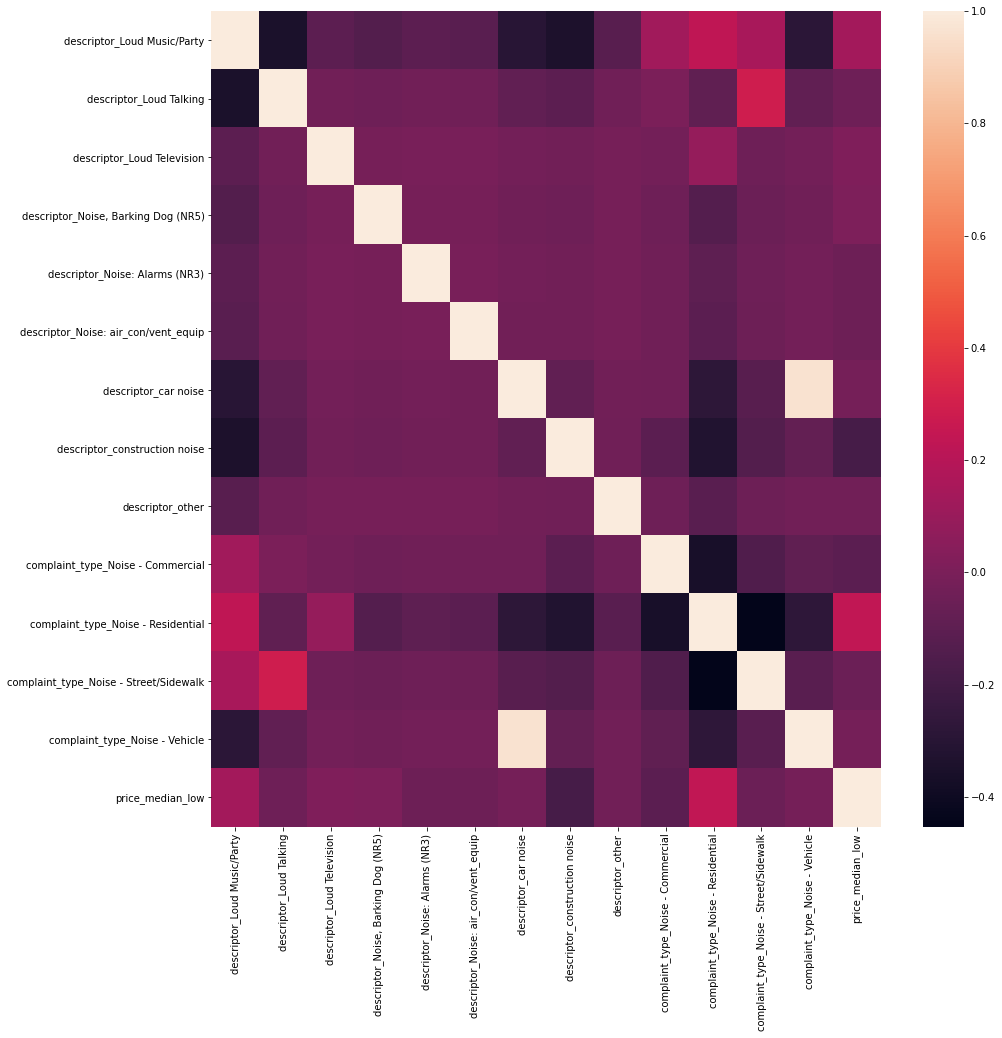

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_dum.corr(), annot=False, ax=ax)
ax.set_ylim([df_dum.shape[1], 0])
plt.show()

In [45]:
df_dum.columns

Index(['descriptor_Loud Music/Party', 'descriptor_Loud Talking',
       'descriptor_Loud Television', 'descriptor_Noise, Barking Dog (NR5)',
       'descriptor_Noise: Alarms (NR3)',
       'descriptor_Noise: air_con/vent_equip', 'descriptor_car noise',
       'descriptor_construction noise', 'descriptor_other',
       'complaint_type_Noise - Commercial',
       'complaint_type_Noise - Residential',
       'complaint_type_Noise - Street/Sidewalk',
       'complaint_type_Noise - Vehicle', 'price_median_low'],
      dtype='object')

In [108]:
# Separate target variable
X = df_dum.copy()
y = X.pop('price_low')

In [109]:
# Baseline
y.value_counts(normalize=True)

0    0.504658
1    0.495342
Name: price_low, dtype: float64

In [110]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

In [111]:
# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [112]:
# Fit logistic regression
model = LogisticRegression(penalty='none')
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5)

print(model.score(X_train, y_train))
print(scores)
print(np.mean(scores))
print(model.score(X_test, y_test))

0.6209048051687568
[0.62078115 0.62047149 0.62153969 0.62034649 0.62138521]
0.6209048054417179
0.620159549080661


In [46]:
df_dum.columns

Index(['descriptor_Loud Music/Party', 'descriptor_Loud Talking',
       'descriptor_Loud Television', 'descriptor_Noise, Barking Dog (NR5)',
       'descriptor_Noise: Alarms (NR3)',
       'descriptor_Noise: air_con/vent_equip', 'descriptor_car noise',
       'descriptor_construction noise', 'descriptor_other',
       'complaint_type_Noise - Commercial',
       'complaint_type_Noise - Residential',
       'complaint_type_Noise - Street/Sidewalk',
       'complaint_type_Noise - Vehicle', 'price_median_low'],
      dtype='object')

In [49]:
c = df_dum[['descriptor_Loud Music/Party', 'descriptor_Loud Talking',
       'descriptor_Loud Television', 'descriptor_Noise, Barking Dog (NR5)',
       'descriptor_Noise: Alarms (NR3)',
       'descriptor_Noise: air_con/vent_equip',
       'descriptor_car noise', 'descriptor_construction noise',
       'descriptor_other', 'price_median_low']]

In [50]:
complaints = pd.get_dummies(c, drop_first=True)

In [51]:
# Try separating complaints and descriptors

In [52]:
d = df_dum[['complaint_type_Noise - Commercial', 'complaint_type_Noise - Residential',
       'complaint_type_Noise - Street/Sidewalk',
       'complaint_type_Noise - Vehicle', 'price_median_low']]

In [54]:
d.columns

Index(['complaint_type_Noise - Commercial',
       'complaint_type_Noise - Residential',
       'complaint_type_Noise - Street/Sidewalk',
       'complaint_type_Noise - Vehicle', 'price_median_low'],
      dtype='object')

In [55]:
descriptors = pd.get_dummies(d, drop_first=True)

In [172]:
d_dum.price_low.value_counts(normalize=True)

0    0.504658
1    0.495342
Name: price_low, dtype: float64

<ipython-input-56-898600bbdc0a>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(pref_corr, dtype=np.bool)


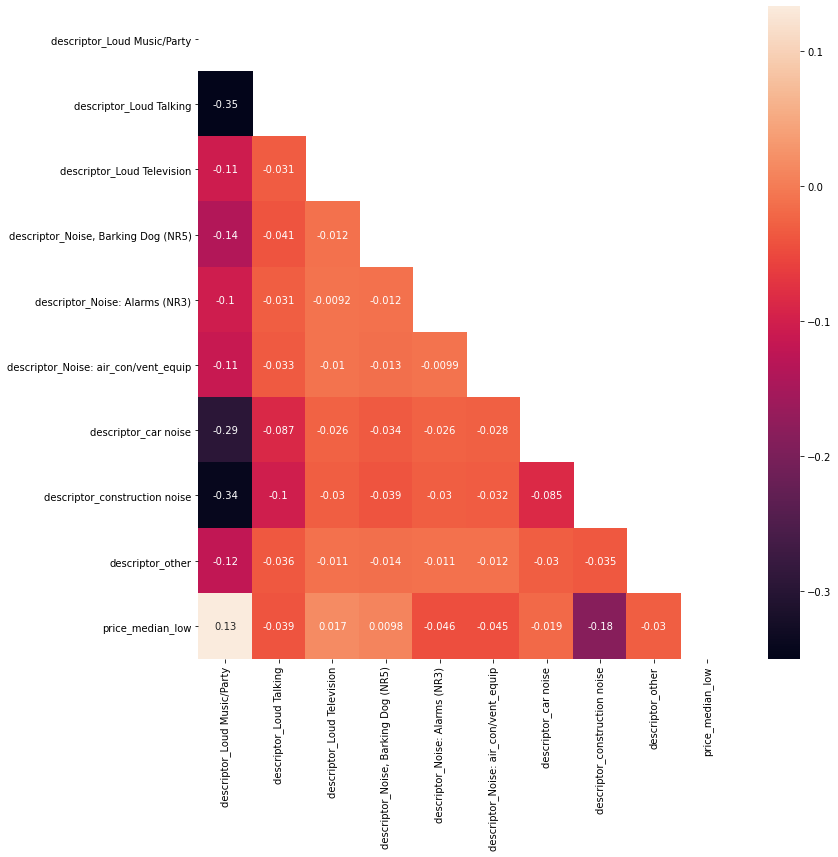

In [56]:
pref_corr = complaints.corr()

mask = np.zeros_like(pref_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(pref_corr, mask=mask, annot=True, ax=ax)
ax.set_ylim([pref_corr.shape[1], 0])
plt.show()



<ipython-input-57-04b2fcfefb82>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(pref_corr, dtype=np.bool)


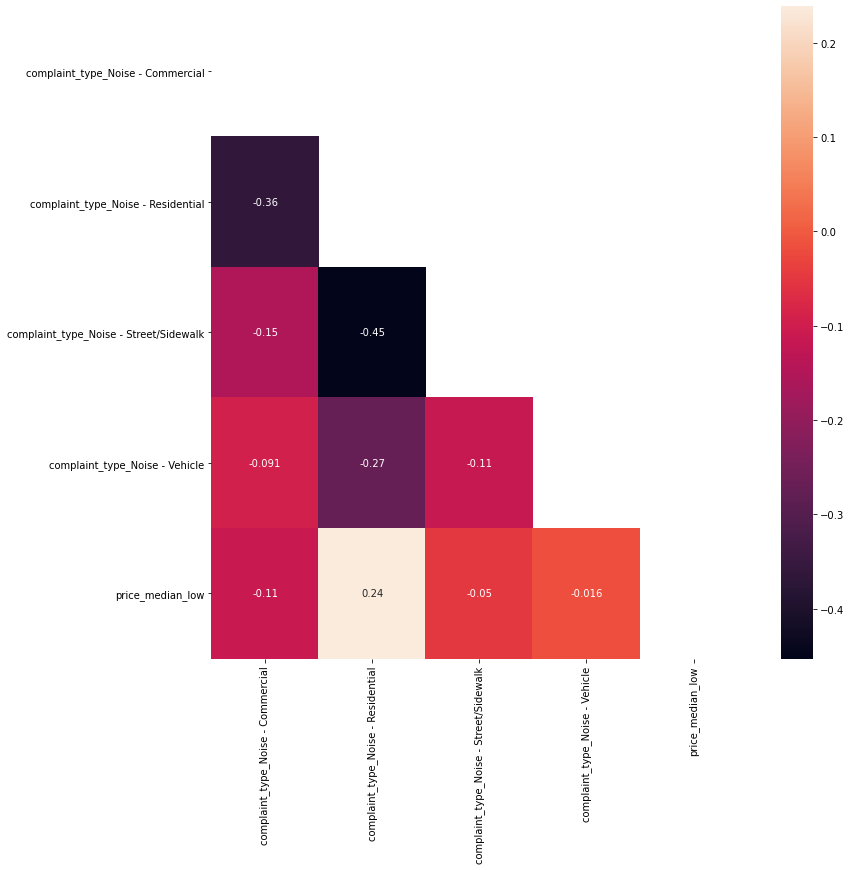

In [57]:
pref_corr = descriptors.corr()

mask = np.zeros_like(pref_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(pref_corr, mask=mask, annot=True, ax=ax)
ax.set_ylim([pref_corr.shape[1], 0])
plt.show()


##### Tried running PCA on model with complaint types only as features and later with descriptors only as features. This didn't tell me much so I didn't scale it up.

In [117]:
descriptor_pca = PCA(n_components=5)
descriptor_pca.fit(d_dum)

PCA(n_components=5)

In [118]:
desc_components = descriptor_pca.components_

In [119]:
descr_to_pcs = descriptor_pca.transform(d_dum)

In [120]:
print(np.corrcoef(descr_to_pcs.T))

[[ 1.00000000e+00 -1.50463811e-13 -7.95363758e-14  2.10791260e-14
  -4.74275468e-15]
 [-1.50463811e-13  1.00000000e+00  1.00178644e-13  1.04025059e-14
  -2.54233132e-14]
 [-7.95363758e-14  1.00178644e-13  1.00000000e+00 -2.27220397e-13
   1.07084081e-17]
 [ 2.10791260e-14  1.04025059e-14 -2.27220397e-13  1.00000000e+00
  -6.15845793e-14]
 [-4.74275468e-15 -2.54233132e-14  1.07084081e-17 -6.15845793e-14
   1.00000000e+00]]


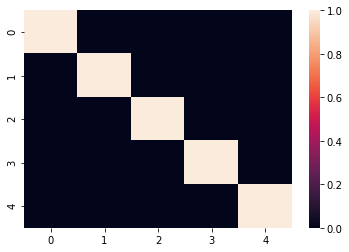

In [121]:
sns.heatmap(np.corrcoef(descr_to_pcs.T))
plt.show()

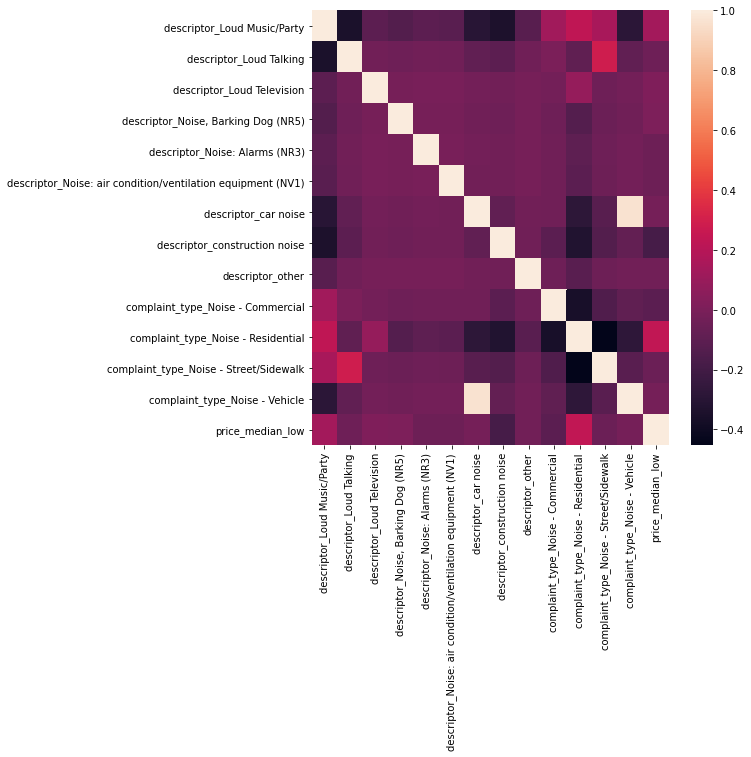

In [286]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df_dum.corr(), annot=False, ax=ax)
ax.set_ylim([df_dum.shape[1], 0])
plt.show()

In [123]:
len(X.columns)

13

In [124]:
X = d_dum.copy()
y = X.pop('price_low')

In [129]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

In [130]:
# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [131]:
model = LogisticRegression(penalty='none')
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5)

print(model.score(X_train, y_train))
print(scores)
print(np.mean(scores))
print(model.score(X_test, y_test))

0.5790714442779633
[0.5794876  0.5784336  0.57984556 0.57809837 0.57949209]
0.5790714445169716
0.5782926884701926


In [133]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA()),
                 ('linreg', LogisticRegression())])

for i in range(1, 14):
    print('number of components:', i)
    pipe.set_params(pca__n_components=i)
    pipe.fit(X_train, y_train)
    print('training score:', (pipe.score(X_train, y_train)))
    print('cv score:', (cross_val_score(pipe, X_train, y_train, cv=5).mean()))
    print('test score:', (pipe.score(X_train, y_train)))

number of components: 1
training score: 0.5659825030014903
cv score: 0.5659825026677526
test score: 0.5659825030014903
number of components: 2
training score: 0.5659825030014903
cv score: 0.5659825026677526
test score: 0.5659825030014903
number of components: 3
training score: 0.5659825030014903
cv score: 0.5659825026677526
test score: 0.5659825030014903
number of components: 4
training score: 0.5659825030014903
cv score: 0.5659825026677526
test score: 0.5659825030014903
number of components: 5
training score: 0.5670245727315238
cv score: 0.5670245725466195
test score: 0.5670245727315238
number of components: 6
training score: 0.5670245727315238
cv score: 0.5670245725466195
test score: 0.5670245727315238
number of components: 7
training score: 0.5670245727315238
cv score: 0.5670245725466195
test score: 0.5670245727315238
number of components: 8
training score: 0.5685746088403196
cv score: 0.5685746086528345
test score: 0.5685746088403196
number of components: 9
training score: 0.579071

ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'

In [134]:
ct = drop[['complaint_type', 'price']]

In [135]:
ct_dum = pd.get_dummies(ct, drop_first=True)

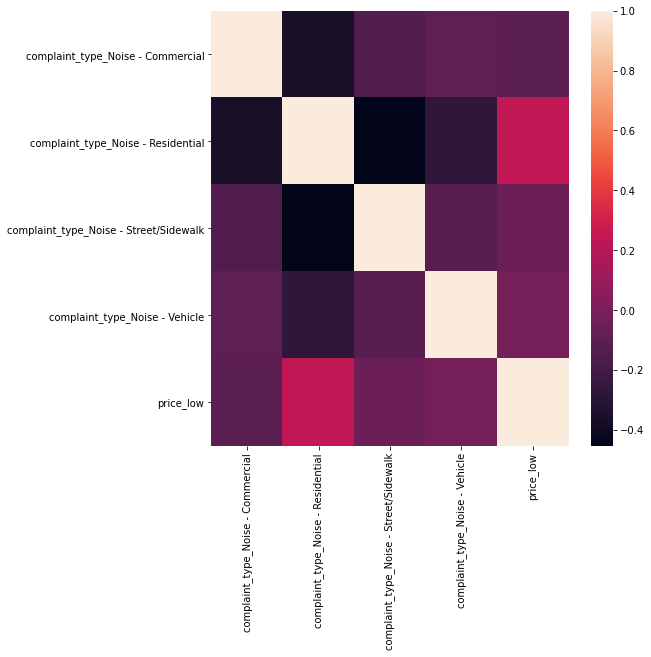

In [136]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(ct_dum.corr(), annot=False, ax=ax)
ax.set_ylim([ct_dum.shape[1], 0])
plt.show()

<ipython-input-137-01965afd135e>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(pref_corr, dtype=np.bool)


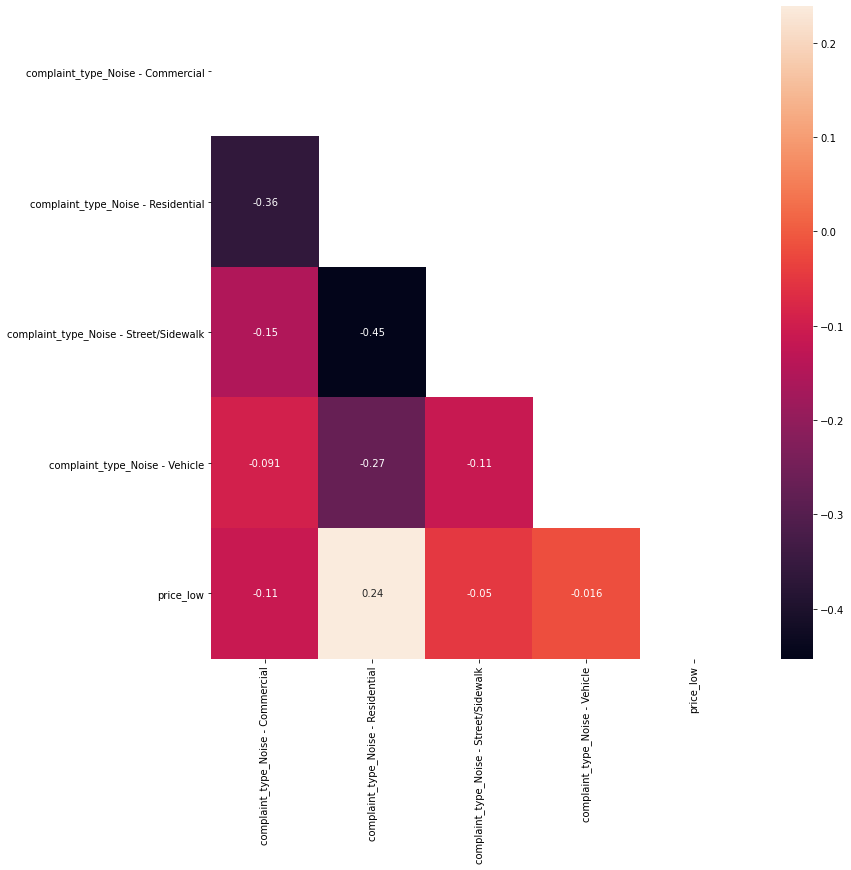

In [137]:
pref_corr = ct_dum.corr()

mask = np.zeros_like(pref_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(pref_corr, mask=mask, annot=True, ax=ax)
ax.set_ylim([len(pref_corr), 0])
plt.show()

Try running PCA on this subset to see if it helps improve scores. It doesn't!

In [138]:
ct_pca = PCA(n_components=5)
ct_pca.fit(ct_dum)

PCA(n_components=5)

In [139]:
ct_comp = ct_pca.components_

In [140]:
ct_comp

array([[ 1.85994694e-01, -7.54141827e-01,  3.03875864e-01,
         7.67236838e-02, -5.46304874e-01],
       [ 3.46594616e-02, -4.40272085e-01,  3.51321779e-01,
         5.97713653e-02,  8.23383024e-01],
       [ 6.46174623e-01, -2.16237574e-01, -7.03176475e-01,
         1.40079176e-01,  1.47038560e-01],
       [-5.58412666e-01, -1.85817611e-01, -3.06835576e-01,
         7.47996288e-01,  7.69066390e-04],
       [-4.84601224e-01, -3.95150254e-01, -4.42297685e-01,
        -6.41420484e-01,  4.43897645e-02]])

In [141]:
print(ct_pca.explained_variance_ratio_.round(4))
print('-------------------------------------\n')

print(ct_dum.columns.values)
print('-------------------------------------\n')

for i, pc in enumerate(['PC1', 'PC2', 'PC3', 'PC4', 'PC5']):
    print(pc, 'weighting vector:\n', ct_comp[i].round(4))
    print('-------------------------------------\n')

[0.4345 0.2699 0.1628 0.0982 0.0346]
-------------------------------------

['complaint_type_Noise - Commercial' 'complaint_type_Noise - Residential'
 'complaint_type_Noise - Street/Sidewalk' 'complaint_type_Noise - Vehicle'
 'price_low']
-------------------------------------

PC1 weighting vector:
 [ 0.186  -0.7541  0.3039  0.0767 -0.5463]
-------------------------------------

PC2 weighting vector:
 [ 0.0347 -0.4403  0.3513  0.0598  0.8234]
-------------------------------------

PC3 weighting vector:
 [ 0.6462 -0.2162 -0.7032  0.1401  0.147 ]
-------------------------------------

PC4 weighting vector:
 [-0.5584 -0.1858 -0.3068  0.748   0.0008]
-------------------------------------

PC5 weighting vector:
 [-0.4846 -0.3952 -0.4423 -0.6414  0.0444]
-------------------------------------



In [142]:
ct_pcs = ct_pca.transform(ct_dum)

In [143]:
print(np.allclose(np.corrcoef(ct_pcs.T), np.eye(len(ct_pcs.T))))

True


In [144]:
print(ct_pcs)

[[-0.71239943  0.13980489  0.00364421 -0.02752104 -0.00353374]
 [-0.16609455 -0.68357814 -0.14339434 -0.02829011 -0.0479235 ]
 [-0.16609455 -0.68357814 -0.14339434 -0.02829011 -0.0479235 ]
 ...
 [-0.71239943  0.13980489  0.00364421 -0.02752104 -0.00353374]
 [-0.16609455 -0.68357814 -0.14339434 -0.02829011 -0.0479235 ]
 [-0.16609455 -0.68357814 -0.14339434 -0.02829011 -0.0479235 ]]


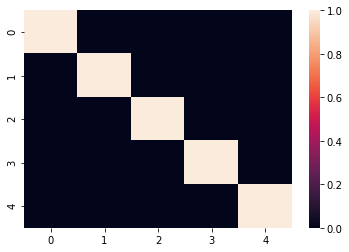

In [145]:
sns.heatmap(np.corrcoef(ct_pcs.T))
plt.show()

Models with only complaint types as features, median as target, no pca

In [159]:
ct_dum.price_low.value_counts(normalize=True)

0    0.504658
1    0.495342
Name: price_low, dtype: float64

In [160]:
X.columns

Index(['complaint_type_Noise - Commercial',
       'complaint_type_Noise - Residential',
       'complaint_type_Noise - Street/Sidewalk',
       'complaint_type_Noise - Vehicle'],
      dtype='object')

In [162]:
X = ct_dum.copy()
y = X.pop('price_low')

In [164]:
# test train split
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.2, random_state=11)

In [165]:
X_train2.columns

Index(['complaint_type_Noise - Commercial',
       'complaint_type_Noise - Residential',
       'complaint_type_Noise - Street/Sidewalk',
       'complaint_type_Noise - Vehicle'],
      dtype='object')

In [154]:
# standardize
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [155]:
model = LogisticRegression(penalty='none')
model.fit(X_train2, y_train2)
scores = cross_val_score(model, X_train2, y_train2, cv=5)

print(model.score(X_train2, y_train2))
print(scores)
print(np.mean(scores))
print(model.score(X_test2, y_test2))

0.6191371503540708
[0.61904532 0.61946862 0.61953113 0.6183578  0.61928288]
0.6191371504368732
0.6183526898338598


In [87]:
# pipe = Pipeline([('scaler', StandardScaler()),
#                  ('pca', PCA()),
#                  ('logreg', LogisticRegression())])

# for i in range(1, 4):
#     print('number of components:', i)
#     pipe.set_params(pca__n_components=i)
#     pipe.fit(X_train2, y_train2)
#     print('training score:', pipe.score(X_train2, y_train2))
#     print('cv score:', cross_val_score(pipe, X_train2, y_train2, cv=5).mean())
#     print('test score:', pipe.score(X_train2, y_train2))

Initial LogReg model score is best with all features included.

Next try decision tree classifier with median as target.

In [329]:
af_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199949 entries, 0 to 445756
Data columns (total 36 columns):
 #   Column                                                            Dtype
---  ------                                                            -----
 0   descriptor_Banging/Pounding                                       uint8
 1   descriptor_Car/Truck Horn                                         uint8
 2   descriptor_Car/Truck Music                                        uint8
 3   descriptor_Engine Idling                                          uint8
 4   descriptor_Loud Music/Party                                       uint8
 5   descriptor_Loud Talking                                           uint8
 6   descriptor_Loud Television                                        uint8
 7   descriptor_NYPD                                                   uint8
 8   descriptor_News Gathering                                         uint8
 9   descriptor_Noise, Barking Dog (NR5) 

In [320]:
X = af_dum.drop(columns=['price_mu_low'])
y = X.pop('price_median_low')

In [326]:
af_dum

,descriptor_Banging/Pounding,descriptor_Car/Truck Horn,descriptor_Car/Truck Music,descriptor_Engine Idling,descriptor_Loud Music/Party,descriptor_Loud Talking,descriptor_Loud Television,descriptor_NYPD,descriptor_News Gathering,"descriptor_Noise, Barking Dog (NR5)",...,complaint_type_Noise,complaint_type_Noise - Commercial,complaint_type_Noise - Helicopter,complaint_type_Noise - House of Worship,complaint_type_Noise - Park,complaint_type_Noise - Residential,complaint_type_Noise - Street/Sidewalk,complaint_type_Noise - Vehicle,price_mu_low,price_median_low
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445752,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
445753,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
445754,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
445755,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [321]:
# Baseline
y.value_counts(normalize=True)

0    0.504658
1    0.495342
Name: price_median_low, dtype: float64

In [322]:
# # test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

# # standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [323]:
# # Fit Decision Tree classifier
classifier_median = DecisionTreeClassifier(criterion='gini',
                                    max_depth=50,
                                    max_features = 30,
                                    min_samples_split = 10000,
                                    ccp_alpha = 0.0001,
                                    random_state=1)
classifier_median.fit(X_train, y_train)
print(classifier_median.score(X_train, y_train))
print(cross_val_score(classifier_median, X_train, y_train, cv=5).mean())
print(classifier_median.score(X_test, y_test))

0.6295629614098964
0.6295362567103042
0.628909747948817


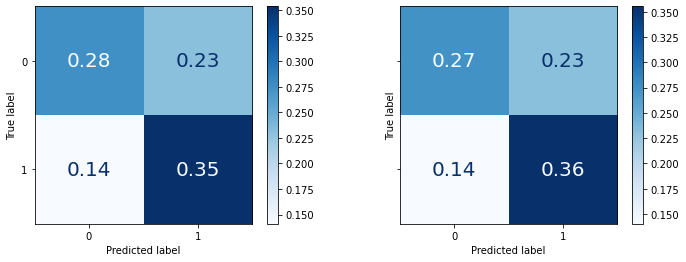

In [331]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(classifier_median, X_train, y_train, cmap='Blues', ax=ax[1], normalize='all')
plot_confusion_matrix(classifier_median, X_test, y_test, cmap='Blues', ax=ax[0], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

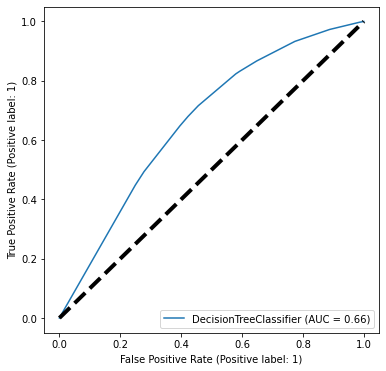

In [328]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(classifier_median, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

In [351]:
fi_med = pd.DataFrame({
    'feature': X.columns,
    'importance': classifier_median.feature_importances_
})

fi_med.sort_values('importance', ascending=False, inplace=True)
fi_med

,feature,importance
31,complaint_type_Noise - Residential,0.630464
2,descriptor_Car/Truck Music,0.100705
32,complaint_type_Noise - Street/Sidewalk,0.082774
15,descriptor_Noise: Construction Before/After Ho...,0.040947
5,descriptor_Loud Talking,0.040258
9,"descriptor_Noise, Barking Dog (NR5)",0.032934
30,complaint_type_Noise - Park,0.019912
0,descriptor_Banging/Pounding,0.018418
17,descriptor_Noise: Jack Hammering (NC2),0.009901
4,descriptor_Loud Music/Party,0.007973


<AxesSubplot:>

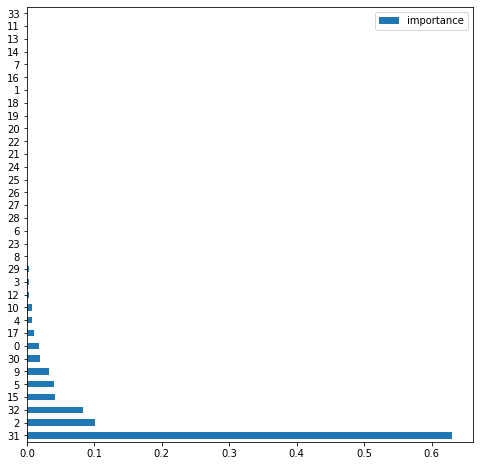

In [350]:
fi.plot(kind='barh', figsize = (8,8))

Try running DTC with mean as target.

In [444]:
X = af_dum.drop(columns=['price_median_low'])
y = X.pop('price_mu_low')

In [445]:
# Baseline
y.value_counts(normalize=True)

1    0.708656
0    0.291344
Name: price_mu_low, dtype: float64

In [446]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

In [448]:
# # Fit Decision Tree classifier
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=50,
                                    max_features = 30,
                                    min_samples_split = 10000,
                                    ccp_alpha = 0.0001,
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

0.7482867498617866
0.7482867499018173
0.7477147207891088


In [358]:
fi = pd.DataFrame({
    'feature': X.columns,
    'importance': classifier.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
31,complaint_type_Noise - Residential,0.478549
15,descriptor_Noise: Construction Before/After Ho...,0.185164
2,descriptor_Car/Truck Music,0.102308
32,complaint_type_Noise - Street/Sidewalk,0.085459
4,descriptor_Loud Music/Party,0.043410
9,"descriptor_Noise, Barking Dog (NR5)",0.027792
13,descriptor_Noise: Alarms (NR3),0.019001
27,complaint_type_Noise - Commercial,0.014413
17,descriptor_Noise: Jack Hammering (NC2),0.013346
5,descriptor_Loud Talking,0.009049


<AxesSubplot:>

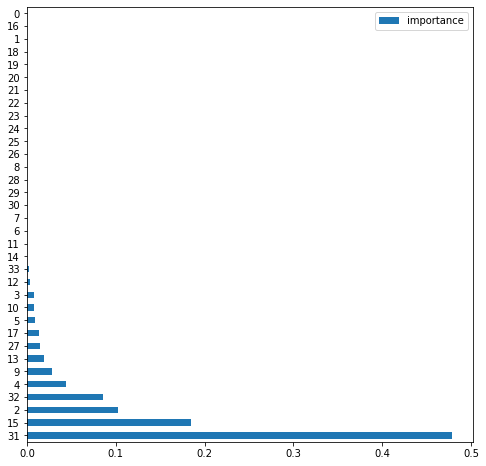

In [359]:
fi.plot(kind='barh', figsize = (8,8))

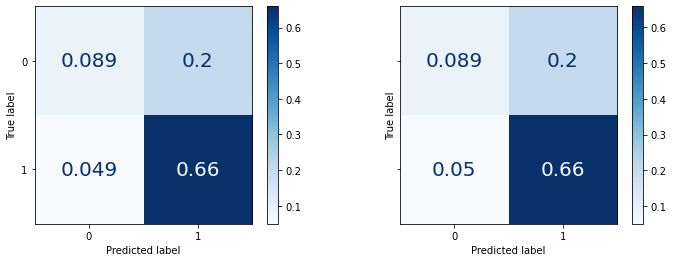

In [455]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(classifier, X_train, y_train, cmap='Blues', ax=ax[0], normalize='all')
plot_confusion_matrix(classifier, X_test, y_test, cmap='Blues', ax=ax[1], normalize='all')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [153]:
predictions = classifier.predict(X_test)

array([1, 1, 1, ..., 0, 1, 0], dtype=uint8)

In [163]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.6403    0.3047    0.4129    128108
           1     0.7650    0.9297    0.8393    311882

    accuracy                         0.7477    439990
   macro avg     0.7026    0.6172    0.6261    439990
weighted avg     0.7287    0.7477    0.7152    439990



In [164]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
# Precision Score: Correctness for positive class predictions

In [ ]:
# Recall How many times the predicted label was positive out of all the times the true label was positive.

In [166]:
# TNR
recall_score(y_test == 0, predictions == 0)


0.30465700814937396

In [165]:
# FPR
1 - recall_score(y_test == 0, predictions == 0)

0.695342991850626

In [173]:
Y_pp = pd.DataFrame(classifier.predict_proba(X_test), 
             columns=['class_0_pp', 'class_1_pp'])

In [174]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

In [456]:
# fraction of 1s predicted at threshold=0.5
classifier.predict(X_test).mean()

0.8614673060751381

In [459]:
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.7)
Y_pp.head(10)

,class_0_pp,class_1_pp,pred_class_thresh
0,0.162377,0.837623,1
1,0.162377,0.837623,1
2,0.234715,0.765285,1
3,0.162797,0.837203,1
4,0.162377,0.837623,1
5,0.456995,0.543005,0
6,0.593846,0.406154,0
7,0.248739,0.751261,1
8,0.248739,0.751261,1
9,0.212023,0.787977,1


In [462]:
Y_pp.pred_class_thresh.value_counts(normalize=True)

1    0.707791
0    0.292209
Name: pred_class_thresh, dtype: float64

In [498]:
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.53)
Y_pp.head(10)

,class_0_pp,class_1_pp,pred_class_thresh
0,0.162377,0.837623,1
1,0.162377,0.837623,1
2,0.234715,0.765285,1
3,0.162797,0.837203,1
4,0.162377,0.837623,1
5,0.456995,0.543005,1
6,0.593846,0.406154,0
7,0.248739,0.751261,1
8,0.248739,0.751261,1
9,0.212023,0.787977,1


In [499]:
Y_pp.pred_class_thresh.mean()

0.8614673060751381

In [500]:
Y_pp.pred_class_thresh.value_counts(normalize=True)

1    0.861467
0    0.138533
Name: pred_class_thresh, dtype: float64

In [ ]:
# Accuracy is highest at .41

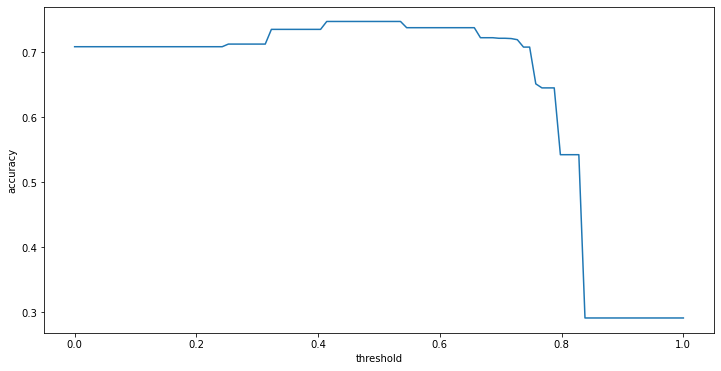

In [187]:
accuracies = np.array(
    [(i, accuracy_score(y_test, Y_pp.class_1_pp.apply(predict_at_threshold, threshold=i))) 
        for i in np.linspace(0, 1, 100)])
plt.figure(figsize=(12, 6))
plt.plot(accuracies[:, 0], accuracies[:, 1])
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

In [188]:
accuracies[accuracies[:, 1].argmax()]

array([0.41414141, 0.74771472])

In [189]:
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve

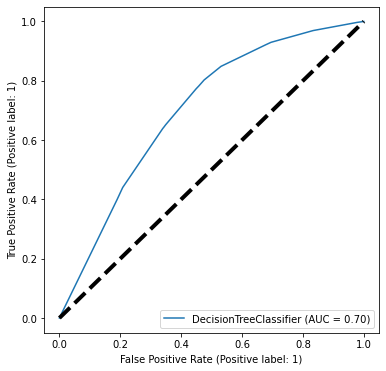

In [198]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(classifier, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()

In [199]:
roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])

0.7019541072075806

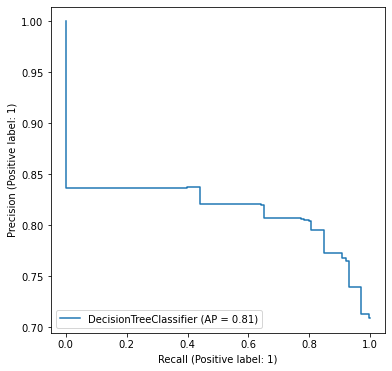

In [200]:
# Plot of a precision-recall curve for class 1 (low price)
plt.fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(classifier, X_test, y_test, ax=ax)
plt.show()

In [269]:
# gridsearch params
dtc_params = {
    'max_depth': [15, 20, 25, 30, 0, 100],
    'max_features': [5, 10, 20, 30],
    'min_samples_split': [1000, 10000, 1000000, 1500000],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}


# set the gridsearch
dtc = DecisionTreeClassifier()
dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, verbose=1)

In [385]:
# # use the gridearch model to fit the data
# dtc_gs.fit(X_train, y_train)
# dtc_best = dtc_gs.best_estimator_
# print(dtc_gs.best_params_)
# print(dtc_gs.best_score_)

Try running Knn with binary target

In [240]:
# knn = KNeighborsClassifier()
# k_range = list(range(9, 10))
# param_grid = dict(n_neighbors=k_range)
  
# # defining parameter range
# grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=True,verbose=1)
  
# # fitting the model for grid search
# grid_search=grid.fit(X_train, y_train)

Try running multiclass model, split on quartiles

In [337]:
m = all_merged.copy()

In [338]:
m

,descriptor,complaint_type,zipyear,ppu
0,Loud Music/Party,Noise - Residential,104632016,3.407297e+05
1,Loud Music/Party,Noise - Residential,100402016,5.457485e+05
2,Loud Talking,Noise - Residential,100122016,3.715735e+06
3,Loud Music/Party,Noise - Residential,111042016,3.813583e+05
4,Loud Music/Party,Noise - Residential,100322016,5.006615e+05
...,...,...,...,...
445752,Loud Music/Party,Noise - Residential,104582017,2.442623e+05
445753,Loud Music/Party,Noise - Residential,116912017,3.044278e+05
445754,Banging/Pounding,Noise - Residential,112142017,4.793599e+05
445755,Loud Music/Party,Noise - Residential,100402017,5.692389e+05


In [339]:
m.drop(columns=['zipyear'], inplace=True)

In [340]:
m['multi'] = pd.qcut(m['ppu'], q=4, labels=[1, 2, 3, 4])

In [343]:
Q1 = m['ppu'].quantile(0.25)
Q2 = m['ppu'].quantile(0.5)
Q3 = m['ppu'].quantile(0.75)

In [344]:
Q1

345437.7398638192

In [346]:
Q2

512594.4991957612

In [345]:
Q3

940156.0076624764

<AxesSubplot:xlabel='multi', ylabel='Count'>

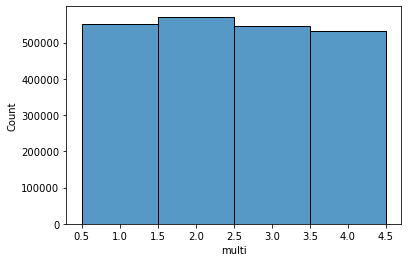

In [341]:
sns.histplot(data=m['multi'])

In [347]:
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2199949 entries, 0 to 445756
Data columns (total 4 columns):
 #   Column          Dtype   
---  ------          -----   
 0   descriptor      object  
 1   complaint_type  object  
 2   ppu             float64 
 3   multi           category
dtypes: category(1), float64(1), object(2)
memory usage: 69.2+ MB


In [348]:
m.drop(columns = ['ppu'], inplace=True)

In [349]:
m.drop_duplicates(inplace=True)

In [350]:
mdum = pd.get_dummies(m, columns = ['descriptor', 'complaint_type'], drop_first=True)

In [351]:
mdum

,multi,descriptor_Banging/Pounding,descriptor_Car/Truck Horn,descriptor_Car/Truck Music,descriptor_Engine Idling,descriptor_Loud Music/Party,descriptor_Loud Talking,descriptor_Loud Television,descriptor_NYPD,descriptor_News Gathering,...,descriptor_Noise: air condition/ventilation equipment (NV1),descriptor_Other,complaint_type_Noise,complaint_type_Noise - Commercial,complaint_type_Noise - Helicopter,complaint_type_Noise - House of Worship,complaint_type_Noise - Park,complaint_type_Noise - Residential,complaint_type_Noise - Street/Sidewalk,complaint_type_Noise - Vehicle
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,4,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,2,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
15,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [356]:
X = mdum.copy()
y = X.pop('multi')

In [362]:
# Baseline
y.value_counts(normalize=True)

3    0.253165
4    0.253165
1    0.246835
2    0.246835
Name: multi, dtype: float64

In [358]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1)

In [359]:
X_traink, X_testk, y_traink, y_testk = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [360]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), 
                       columns=X_train.columns, 
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), 
                      columns=X_test.columns, 
                      index=X_test.index)

Used RandomizedSearchCV because regular gridsearch was taking ages

In [204]:
random_grid = {'solver':['saga'],
               'tol': [0.00001, 0.0001,0.001, 0.01],
               'multi_class': ['ovr'],
               'l1_ratio' : [.1, .25, .4, .75, .9],
              'fit_intercept': [True, False],}
               
model = LogisticRegression(penalty ='elasticnet', max_iter=1000,)

In [208]:

rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 35, cv = 10, 
                               verbose=2, random_state=35, n_jobs = -1)


In [209]:
rf_random.estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [210]:
rf_random.fit(X_train,y_train)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


RandomizedSearchCV(cv=10,
                   estimator=LogisticRegression(max_iter=1000,
                                                penalty='elasticnet'),
                   n_iter=35, n_jobs=-1,
                   param_distributions={'fit_intercept': [True, False],
                                        'l1_ratio': [0.1, 0.25, 0.4, 0.75, 0.9],
                                        'multi_class': ['ovr'],
                                        'solver': ['saga'],
                                        'tol': [1e-05, 0.0001, 0.001, 0.01]},
                   random_state=35, verbose=2)

In [211]:
rf_random.best_params_

{'tol': 0.001,
 'solver': 'saga',
 'multi_class': 'ovr',
 'l1_ratio': 0.75,
 'fit_intercept': False}

In [361]:
model = LogisticRegression(penalty='none', max_iter=1000, tol=.001, multi_class='ovr', solver='saga',)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5)

print(model.score(X_train, y_train))
print(scores)
print(np.mean(scores))
print(model.score(X_test, y_test))

0.31746031746031744
[0.03846154 0.04       0.04       0.         0.04      ]
0.0316923076923077
0.03125


In [143]:
mdum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 414384
Data columns (total 35 columns):
 #   Column                                                            Non-Null Count  Dtype   
---  ------                                                            --------------  -----   
 0   multi                                                             158 non-null    category
 1   descriptor_Banging/Pounding                                       158 non-null    uint8   
 2   descriptor_Car/Truck Horn                                         158 non-null    uint8   
 3   descriptor_Car/Truck Music                                        158 non-null    uint8   
 4   descriptor_Engine Idling                                          158 non-null    uint8   
 5   descriptor_Loud Music/Party                                       158 non-null    uint8   
 6   descriptor_Loud Talking                                           158 non-null    uint8   
 7   descriptor_Loud Televis

Knn model with multiclass target. Had to majorly scale down my Knn params because it was taking days to run.

In [144]:
knn = KNeighborsClassifier()
k_range = list(range(5, 40))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)


Fitting 10 folds for each of 35 candidates, totalling 350 fits


In [145]:
grid_search.best_params_

{'n_neighbors': 36}

In [159]:
knn = KNeighborsClassifier()
k_range = list(range(5, 100))
param_grid = dict{'n_neighbors': k_range}
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=True,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_traink, y_traink)

Fitting 10 folds for each of 95 candidates, totalling 950 fits


In [160]:
grid_search.best_score_

0.2467948717948718

In [155]:
X_train

,descriptor_Banging/Pounding,descriptor_Car/Truck Horn,descriptor_Car/Truck Music,descriptor_Engine Idling,descriptor_Loud Music/Party,descriptor_Loud Talking,descriptor_Loud Television,descriptor_NYPD,descriptor_News Gathering,"descriptor_Noise, Barking Dog (NR5)",...,descriptor_Noise: air condition/ventilation equipment (NV1),descriptor_Other,complaint_type_Noise,complaint_type_Noise - Commercial,complaint_type_Noise - Helicopter,complaint_type_Noise - House of Worship,complaint_type_Noise - Park,complaint_type_Noise - Residential,complaint_type_Noise - Street/Sidewalk,complaint_type_Noise - Vehicle
1621,-0.324443,-0.223607,-0.203279,-0.156174,-0.394922,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,1.274755,-0.421391,-0.293610,-0.324443,-0.260378,-0.353553,-0.156174,-0.260378
405,-0.324443,-0.223607,-0.203279,6.403124,-0.394922,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,-0.784465,-0.421391,-0.293610,-0.324443,-0.260378,-0.353553,-0.156174,3.840573
2133,-0.324443,-0.223607,4.919350,-0.156174,-0.394922,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,-0.784465,2.373095,-0.293610,-0.324443,-0.260378,-0.353553,-0.156174,-0.260378
2584,-0.324443,-0.223607,-0.203279,-0.156174,-0.394922,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,1.274755,-0.421391,-0.293610,-0.324443,-0.260378,-0.353553,-0.156174,-0.260378
1602,-0.324443,-0.223607,-0.203279,-0.156174,-0.394922,2.720294,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,-0.784465,-0.421391,-0.293610,3.082207,-0.260378,-0.353553,-0.156174,-0.260378
16490,-0.324443,-0.223607,-0.203279,-0.156174,-0.394922,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,-0.784465,-0.421391,-0.293610,-0.324443,-0.260378,-0.353553,-0.156174,-0.260378
28,-0.324443,-0.223607,-0.203279,-0.156174,2.532146,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,-0.784465,-0.421391,-0.293610,-0.324443,3.840573,-0.353553,-0.156174,-0.260378
138795,-0.324443,-0.223607,-0.203279,-0.156174,-0.394922,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,1.274755,-0.421391,-0.293610,-0.324443,-0.260378,-0.353553,-0.156174,-0.260378
56817,-0.324443,-0.223607,-0.203279,-0.156174,-0.394922,-0.367607,-0.223607,-0.156174,-0.181071,-0.089443,...,-0.156174,-0.156174,1.274755,-0.421391,-0.293610,-0.324443,-0.260378,-0.353553,-0.156174,-0.260378
16542,-0.324443,-0.223607,-0.203279,-0.156174,-0.394922,-0.367607,-0.223607,6.403124,-0.181071,-0.089443,...,-0.156174,-0.156174,-0.784465,-0.421391,3.405877,-0.324443,-0.260378,-0.353553,-0.156174,-0.260378
